In [1]:
import adept_envs
import gym
import glob
import os
from parse_mjl import parse_mjl_logs
from tqdm import tqdm
import numpy as np

In [2]:
env = gym.make("kitchen_relax-v1")

Reading configurations for Franka
Initializing Franka sim
registering the liscence


/home/sholto/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [3]:
obs = env.reset()


In [4]:
demo_dir = os.getcwd() + '/' + "kitchen_demos_multitask/"

demos = glob.glob(demo_dir + "/**/*.mjl", recursive=True)
print([d.strip(demo_dir) for d in demos])

['b_bottomknob_hinge/kitchen_playdata_2019_07_11_18_06_46.mj', 'b_bottomknob_hinge/kitchen_playdata_2019_07_11_18_05_26.mj', 'b_bottomknob_hinge/kitchen_playdata_2019_07_11_18_05_06.mj', 'b_bottomknob_hinge/kitchen_playdata_2019_07_11_18_02_41.mj', 'b_bottomknob_hinge/kitchen_playdata_2019_07_11_18_04_03.mj', 'b_bottomknob_hinge/kitchen_playdata_2019_07_11_18_04_24.mj', 'b_bottomknob_hinge/kitchen_playdata_2019_07_11_18_01_21.mj', 'b_bottomknob_hinge/kitchen_playdata_2019_07_11_18_02_01.mj', 'b_bottomknob_hinge/kitchen_playdata_2019_07_11_18_01_41.mj', 'b_bottomknob_hinge/kitchen_playdata_2019_07_11_18_03_42.mj', 'b_bottomknob_hinge/kitchen_playdata_2019_07_11_18_07_06.mj', 'b_bottomknob_hinge/kitchen_playdata_2019_07_11_18_03_01.mj', 'b_bottomknob_hinge/kitchen_playdata_2019_07_11_18_04_45.mj', 'b_bottomknob_hinge/kitchen_playdata_2019_07_11_18_07_44.mj', 'b_bottomknob_hinge/kitchen_playdata_2019_07_11_18_02_21.mj', 'b_bottomknob_hinge/kitchen_playdata_2019_07_11_18_06_06.mj', 'b_bott

In [5]:
file = demos[1]
skip = 20
data = parse_mjl_logs(file, skip)
data

{'nq': 30,
 'nv': 29,
 'nu': 9,
 'nmocap': 1,
 'nsensordata': 0,
 'name': b'franka_mocap_studyTable_buttons',
 'time': array([ 2.19400001,  2.23399997,  2.27399993,  2.31399989,  2.35400009,
         2.39400005,  2.43400002,  2.47399998,  2.51399994,  2.5539999 ,
         2.5940001 ,  2.63400006,  2.67400002,  2.71399999,  2.75399995,
         2.79399991,  2.83400011,  2.87400007,  2.91400003,  2.954     ,
         2.99399996,  3.03399992,  3.07399988,  3.11400008,  3.15400004,
         3.19400001,  3.23399997,  3.27399993,  3.31399989,  3.35400009,
         3.39400005,  3.43400002,  3.47399998,  3.51399994,  3.5539999 ,
         3.5940001 ,  3.63400006,  3.67400002,  3.71399999,  3.75399995,
         3.79399991,  3.83400011,  3.87400007,  3.91400003,  3.954     ,
         3.99399996,  4.03399992,  4.07399988,  4.11399984,  4.15399981,
         4.19399977,  4.23400021,  4.27400017,  4.31400013,  4.35400009,
         4.39400005,  4.43400002,  4.47399998,  4.51399994,  4.5539999 ,
      

In [6]:
%matplotlib inline 
import matplotlib.pyplot as plt
def histo(x):
    hist, bins = np.histogram(x, bins=50)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.bar(center, hist, align='center', width=width)
    plt.title("Trajectory Lengths")
    plt.show()


100%|██████████| 608/608 [00:22<00:00, 27.31it/s]

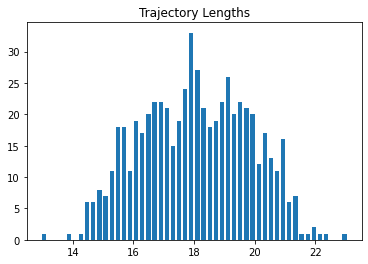

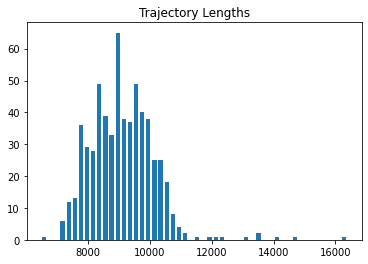

In [43]:
times = []
frames = []
timestep = []

for file in tqdm(demos):
    try:
        skip = 1
        data = parse_mjl_logs(file, skip)
        times.append(data['time'][-1] - data['time'][0])
        frames.append(len(data['ctrl']))
    except:
        pass

histo(times)
histo(frames)

In [7]:
print(data['ctrl'].shape, data['qpos'].shape, data['qvel'].shape)

(454, 9) (454, 30) (454, 29)


In [6]:
file = demos[np.random.choice(len(demos))]
skip = 40 # this is frame skip
data = parse_mjl_logs(file, skip)
env.reset()
for i in range(0,len(data['qpos'])):
    env.robot.reset(env, data['qpos'][i], data['qvel'][i])
    env.render()

# The issue!
Now, the problem is that cntrl is at the full time frequency of the env - which is really fine. That means if frame skip is anything but 1 then the ctrl labels are wrong. Ideally we want a more reasonable time freq, which means we need to take the difference between the first 9 elements of q_pos, divide it by the time between and then that gives us our desired vel controls. Even better, tonight I'll modify the env for position control. 

See, the below fails - 

In [13]:
env.reset()

array([ 1.43264592e-01, -1.77799799e+00,  1.84360213e+00, -2.48067288e+00,
        2.66339894e-01,  7.17807025e-01,  1.59974274e+00,  5.04281322e-02,
        3.76864916e-02, -4.75080366e-05, -2.52327569e-05,  4.69530209e-05,
       -6.29075473e-05, -9.96761684e-06,  5.99427580e-06,  3.48217187e-05,
        5.21325121e-06,  4.25380655e-04, -9.96743683e-05, -5.09636619e-04,
       -2.10016238e-03,  8.16123084e-03,  9.49776479e-03, -2.69737980e-01,
        3.50862365e-01,  1.61924263e+00,  1.00537151e+00,  1.10771256e-02,
       -1.02287991e-02,  1.93989775e-04,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

IndexError: index 97 is out of bounds for axis 0 with size 97

In [7]:
# playback demos and get data(physics respected)
def gather_training_data(env, data, filename='demo_playback.mp4', render=None):
    env = env.env
    FPS = 30
    render_skip = max(1, round(1. / \
        (FPS * env.sim.model.opt.timestep * env.frame_skip)))
    t0 = timer.time()

    # initialize
    env.reset()
    init_qpos = data['qpos'][0].copy()
    init_qvel = data['qvel'][0].copy()
    act_mid = env.act_mid
    act_rng = env.act_amp

    # prepare env
    env.sim.data.qpos[:] = init_qpos
    env.sim.data.qvel[:] = init_qvel
    env.sim.forward()
    #viewer(env, mode='initialize', render=render)

    # step the env and gather data
    path_obs = None
    for i_frame in range(data['ctrl'].shape[0] - 1):
        # Reset every time step
        # if i_frame % 1 == 0:
        #     qp = data['qpos'][i_frame].copy()
        #     qv = data['qvel'][i_frame].copy()
        #     env.sim.data.qpos[:] = qp
        #     env.sim.data.qvel[:] = qv
        #     env.sim.forward()

        obs = env._get_obs()

        # Construct the action
        # ctrl = (data['qpos'][i_frame + 1][:9] - obs[:9]) / (env.skip * env.model.opt.timestep)
        ctrl = (data['ctrl'][i_frame] - obs[:9])/(env.skip*env.model.opt.timestep)
        act = (ctrl - act_mid) / act_rng
        act = np.clip(act, -0.999, 0.999)
        next_obs, reward, done, env_info = env.step(act)
        if path_obs is None:
            path_obs = obs
            path_act = act
        else:
            path_obs = np.vstack((path_obs, obs))
            path_act = np.vstack((path_act, act))

        # render when needed to maintain FPS
        if i_frame % render_skip == 0:
            #viewer(env, mode='render', render=render)
            print(i_frame, end=', ', flush=True)
            env.render()
#     # finalize
#     if render:
#         viewer(env, mode='save', filename=filename, render=render)

    t1 = timer.time()
    print("time taken = %f" % (t1 - t0))

    # note that <init_qpos, init_qvel> are one step away from <path_obs[0], path_act[0]>
    return path_obs, path_act, init_qpos, init_qvel

In [12]:


import time as timer
file = demos[np.random.choice(len(demos))]
skip = 40 # this is frame skip
data = parse_mjl_logs(file, skip)
render = True
obs, act,init_qpos, init_qvel = gather_training_data(env, data,\
                filename=data['logName'][:-4]+'_playback.mp4', render=render)

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, time taken = 8.482381


In [29]:
print(len(obs))
env.robot.reset(env, init_qpos, init_qvel)
for i in range(0,len(act)):
    #rel_vector = data['qpos'][i+1][:9]-data['qpos'][i][:9]
    #vel = rel_vector / 0.08
    
    #env.robot.reset(env, data['qpos'][i], data['qvel'][i])
    env.step(act[i]) # the key change
    env.render()

211


In [5]:
glob.glob('./kitchen_demos_multitask/*')

['./kitchen_demos_multitask/postcorl_kettle_topknob_bottomknob_hinge',
 './kitchen_demos_multitask/friday_microwave_bottomknob_switch_slide',
 './kitchen_demos_multitask/friday_microwave_kettle_bottomknob_slide',
 './kitchen_demos_multitask/friday_microwave_kettle_topknob_switch',
 './kitchen_demos_multitask/postcorl_kettle_bottomknob_switch_hinge',
 './kitchen_demos_multitask/friday_microwave_kettle_bottomknob_hinge',
 './kitchen_demos_multitask/friday_microwave_kettle_switch_slide',
 './kitchen_demos_multitask/postcorl_microwave_topknob_bottomknob_switch',
 './kitchen_demos_multitask/postcorl_microwave_switch_hinge_slide',
 './kitchen_demos_multitask/postcorl_microwave_topknob_switch_hinge',
 './kitchen_demos_multitask/friday_microwave_topknob_bottomknob_hinge',
 './kitchen_demos_multitask/friday_kettle_bottomknob_switch_slide',
 './kitchen_demos_multitask/friday_microwave_kettle_topknob_hinge',
 './kitchen_demos_multitask/friday_microwave_topknob_bottomknob_slide',
 './kitchen_demos

In [ ]:
import multiprocessing
import subprocess
import shlex
from multiprocessing.pool import ThreadPool
import glob
def call_proc(cmd):
    """ This runs in a separate thread. """
    p = subprocess.Popen(shlex.split(cmd), stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    out, err = p.communicate()
    return (out, err)

pool = ThreadPool(multiprocessing.cpu_count()//2)
results = []
for path in glob.glob('./kitchen_demos_multitask/*'):
    cmd = f'python3 relay-policy-learning/adept_envs/adept_envs/utils/parse_demos.py --env "kitchen_relax-v1" -d "{path}/" -s "40" -v "playback" -r "offscreen"'
    results.append(pool.apply_async(call_proc, (cmd,)))
# Close the pool and wait for each running task to complete
pool.close()
pool.join()
for result in results:
    out, err = result.get()
    print(f"out: {out.decode()}")
    print(f"err: {err.decode()}")

ERROR:root:Invalid alias: The name clear can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name more can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name less can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name man can't be aliased because it is another magic command.


# Env Info 

## Action Space

Action space is 9 dimensional, commanded via velocity. In franka robot.py, the function cntrl_velocity_limits bounds the desired velocity step, then returns a next desired positon (prevpos + cntrl_vel*step_size), so really rather than absolute position it is commanding desired pos, using a relative offset commanded via velocity assuming a constant timestep (0.08). This means it'd be easy to adapt to commanding via relative positon, or velocity. 

## Obs Space

60 Dimensional. 9 for self, 21 for obs, 30 for goal. Self is unused in reward computation, only the following indices are 



In [ ]:
OBS_ELEMENT_INDICES = {
    'bottom burner': np.array([11, 12]),
    'top burner': np.array([15, 16]),
    'light switch': np.array([17, 18]),
    'slide cabinet': np.array([19]),
    'hinge cabinet': np.array([20, 21]),
    'microwave': np.array([22]),
    'kettle': np.array([23, 24, 25, 26, 27, 28, 29]),
    }

We can reset it to any qpos,qvel self.robot.reset(self, reset_pos, reset_vel) (sizes 30, 29). qvel is actually returned as 30 dimensional internally (but never used so its not an issue. This off by one issue comes from the sim not returning the vel of one of the object elements I think, can't find out which one though. Not a big issue, vel isn't part of the obs state so clearly not that key.

In [8]:
energy_usage = 200000 # TWH
coal_energy_per_ton = 0.00000000029 * 0.001 # Coal energy per ton in Terwatt hours
carbon_produced = 60 # GT
c02_emitted_per_ton = 9.2668921e-11

In [9]:
energy_usage/coal_energy_per_ton

6.896551724137932e+17

In [10]:
carbon_produced/c02_emitted_per_ton

647466263257.7755